In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization, ReLU
from keras.layers import Dropout, Dense, TimeDistributed, Reshape, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
!pip install --upgrade scikit-learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CLASSES = 7

In [17]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/ravdess-full/RAVDESS/Mel_Spectrograms/Train',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/ravdess-full/RAVDESS/Mel_Spectrograms/Test',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

Found 3976 files belonging to 7 classes.
Found 254 files belonging to 7 classes.


In [6]:
# Make a dataset containing the training spectrograms
total_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory='/kaggle/input/crema-full/CREMA/Mel_Spectrograms/Complete',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.3,
                                             directory='/kaggle/input/crema-full/CREMA/Mel_Spectrograms/Complete',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

# Split the train_dataset into training and validation subsets
train_dataset_size = len(total_train_dataset)
train_size = int(0.7 * train_dataset_size)
valid_size = train_dataset_size - train_size

# Take the first train_size elements for training
train_dataset = total_train_dataset.take(train_size)

# Skip the first train_size elements to get the remaining for validation
valid_dataset = total_train_dataset.skip(train_size).take(valid_size)

Found 29768 files belonging to 6 classes.
Using 20838 files for training.
Found 29768 files belonging to 6 classes.
Using 8930 files for validation.


In [7]:
# Count the number of files in each dataset
def count_files(dataset):
    count = 0
    for batch in dataset:
        count += len(batch[0])  # batch[0] contains the images
    return count

# Print the counts
print("Number of files in train_dataset:", count_files(train_dataset))
print("Number of files in valid_dataset:", count_files(valid_dataset))
print("Number of files in test_dataset:", count_files(test_dataset))

Number of files in train_dataset: 14592
Number of files in valid_dataset: 6246
Number of files in test_dataset: 8930


In [23]:
def get_parallel_conv_model():
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    input_layer = Input(shape=input_shape)

    # First CNN branch
    x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x1 = BatchNormalization()(x1)
    x1 = MaxPool2D((2, 2))(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPool2D((4, 4))(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPool2D((4, 4))(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Flatten()(x1)

    # Second CNN branch
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x2 = BatchNormalization()(x2)
    x2 = MaxPool2D((2, 2))(x2)
    x2 = Dropout(0.4)(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPool2D((4, 4))(x2)
    x2 = Dropout(0.4)(x2)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPool2D((4, 4))(x2)
    x2 = Dropout(0.4)(x2)
    x2 = Flatten()(x2)

    # Merging the branches
    merged = concatenate([x1, x2])
    merged = Dense(128, activation='relu')(merged)
    output = Dense(7, activation='softmax')(merged)

    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), metrics=['acc'])
    
    return model

In [ ]:
model = get_parallel_conv_model()

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
# history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, callbacks = [early_stopping], verbose = 1)
history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, verbose = 1)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - acc: 0.2361 - loss: 4.5297 - val_acc: 0.2717 - val_loss: 2.8151
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - acc: 0.3865 - loss: 1.5724 - val_acc: 0.4685 - val_loss: 1.3949
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - acc: 0.4922 - loss: 1.3018 - val_acc: 0.4094 - val_loss: 1.4054
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - acc: 0.5627 - loss: 1.1390 - val_acc: 0.4213 - val_loss: 1.6449
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - acc: 0.6684 - loss: 0.8945 - val_acc: 0.4882 - val_loss: 1.2918
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - acc: 0.7556 - loss: 0.6617 - val_acc: 0.5315 - val_loss: 1.1779
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - acc: 0.8304 - loss: 0.4720 - val_acc: 0.6496 - val_loss: 0.9435
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - acc: 0.8521 - loss: 0.4196 - val_acc: 0.6969 - val_loss: 0.7761
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━

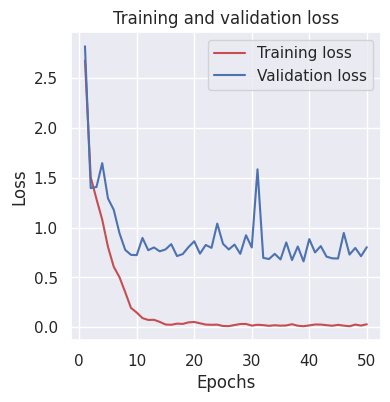

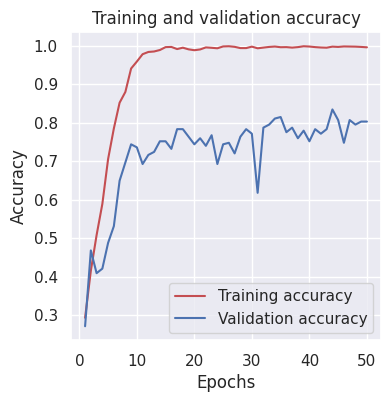

Final loss: 0.073158, final accuracy: 0.998239
Final loss: 0.800653, final accuracy: 0.803150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       0.94      0.77      0.85        39
     Disgust       0.92      0.87      0.89        39
        Fear       0.82      0.79      0.81        39
       Happy       0.66      0.95      0.78        39
     Neutral       0.80      0.80      0.80        20
         Sad       0.65      0.67      0.66        39
    Surprise       0.97      0.77      0.86        39

    accuracy                           0.80       254
   macro avg       0.82      0.80      0.81       254
weighted avg       0.82      0.80      0.81       254



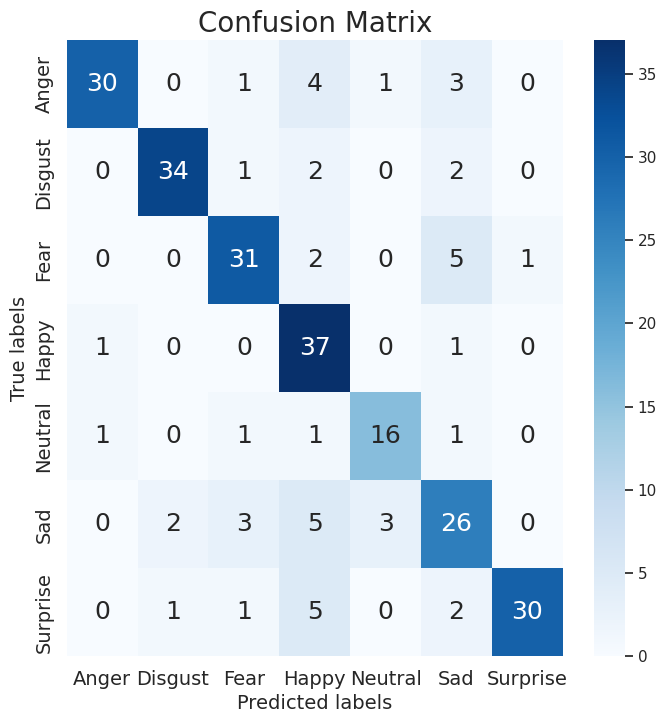

In [27]:
import seaborn as sns
sns.set()

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
    
plt.figure(figsize=(4,4))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation.
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(4,4))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(train_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `test_dataset` contains your test data and labels, and `model` is your trained Keras model
test_images = []
test_labels = []
for images, labels in valid_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Get model predictions on the test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(test_labels, y_pred, target_names=class_names)

# Print the classification report
print('Classification Report:')
print(report)


# Plot the confusion matrix using Seaborn's heatmap function

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=class_names, yticklabels=class_names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('True labels', size=14)
plt.show()